Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .

We  suggest  spending  1­2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  ­­  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable.

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns

In [64]:
users = pd.read_csv('takehome_users.csv',  encoding = "ISO-8859-1")
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])


Let's find the adopted user first. These are the people who have log into the product on three separate days in 7 day periods.  Ideally, I would probably find a better way to get the rolling mean.  However, since the data are large, let's use a window of 7

In [65]:
all_user = engagement.user_id.unique()

adopted = []
for user in all_user:
    temp_df = engagement[engagement.user_id == user].set_index('time_stamp')
    temp_df = temp_df.resample('7D').sum()
    if any(3 <= visited for visited in temp_df.visited.values):
        adopted.append((user,1))
    else:
        adopted.append((user,0))


In [66]:
adopted_user = pd.DataFrame(adopted, columns  = ['user_id', 'adopted_user'])
adopted_user.shape

(8823, 2)

In [67]:
working_df = pd.merge(left= users, left_on='object_id', right=adopted_user  ,right_on='user_id', how='inner') 
#Use inner join because if we don't have a label then we can't really predict anything

Lets clean up some data, we will get rid of some columns that probably doesn't matter, and we will set the index to user_id.

In [68]:
working_df = working_df.set_index('user_id')
working_df = working_df.drop(columns = ['object_id', 'name','email', 'creation_time'])
working_df

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
user_id,,,,,,,
1,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
...,...,...,...,...,...,...,...
11996,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11997,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11998,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0


In [69]:
working_df.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             8823 non-null   object 
 1   last_session_creation_time  8823 non-null   float64
 2   opted_in_to_mailing_list    8823 non-null   int64  
 3   enabled_for_marketing_drip  8823 non-null   int64  
 4   org_id                      8823 non-null   int64  
 5   invited_by_user_id          4776 non-null   float64
 6   adopted_user                8823 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 551.4+ KB


We are missing some value in the invited by_user_id.  We will put zero for Na and 1 for other people

In [70]:
def nan_or_not(x):
    if x == 0:
        return 0 
    else:
        return 1
working_df['invited_by_user_id'] = working_df['invited_by_user_id'].fillna(0).apply(lambda x: nan_or_not(x))
working_df

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
user_id,,,,,,,
1,GUEST_INVITE,1.398139e+09,1,0,11,1,0
2,ORG_INVITE,1.396238e+09,0,0,1,1,1
3,ORG_INVITE,1.363735e+09,0,0,94,1,0
4,GUEST_INVITE,1.369210e+09,0,0,1,1,0
5,GUEST_INVITE,1.358850e+09,0,0,193,1,0
...,...,...,...,...,...,...,...
11996,ORG_INVITE,1.378448e+09,0,0,89,1,0
11997,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0,0
11998,GUEST_INVITE,1.398603e+09,1,1,83,1,0


C:\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


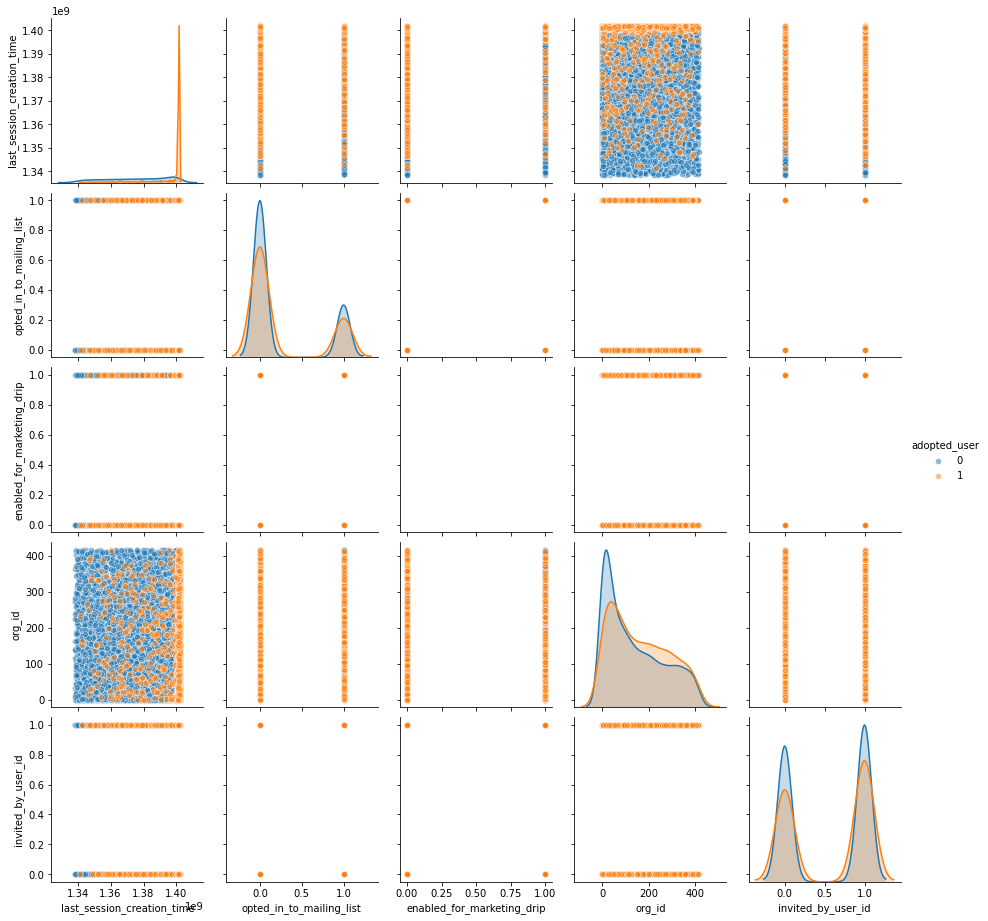

In [71]:
sns.pairplot(working_df, hue = 'adopted_user',  plot_kws={'alpha':0.5})

<AxesSubplot:xlabel='adopted_user,creation_source'>

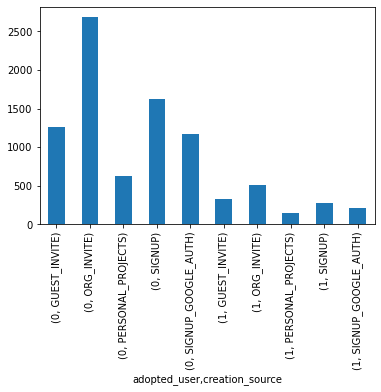

In [72]:
#sns.barplot(x='adopted_user', y='creation_source', data = working_df.groupby, hue = working_df.adopted_user)
working_df.groupby(['adopted_user', 'creation_source'])['org_id'].count().plot.bar()

If they are active users, it appears that they are more likely to have a more recent last session creation time.  That is a reliable indicator.  I think everything else might be a little bit iffy as a single predictor.  There isn't anything co-linear.  

<AxesSubplot:ylabel='adopted_user'>

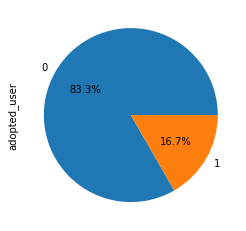

In [73]:
working_df.adopted_user.value_counts().plot.pie(autopct='%1.1f%%') 

In [74]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

working_df_num = working_df.select_dtypes(include=numerics)
working_df_num.corr().round(2).style.background_gradient(cmap='coolwarm') 

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
last_session_creation_time,1.000000,0.010000,0.010000,0.040000,0.000000,0.400000
opted_in_to_mailing_list,0.010000,1.000000,0.490000,-0.000000,0.010000,0.010000
enabled_for_marketing_drip,0.010000,0.490000,1.000000,0.000000,0.000000,0.000000
org_id,0.040000,-0.000000,0.000000,1.000000,-0.020000,0.070000
invited_by_user_id,0.000000,0.010000,0.000000,-0.020000,1.000000,0.020000
adopted_user,0.400000,0.010000,0.000000,0.070000,0.020000,1.000000


The correlation chart looks ok.  Our metric accuracy must be 83% or better.

We will now preprocess the data by using on hot encode to handle category columns, train test split and Scaler for the numeric columns

In [75]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

working_df = pd.get_dummies(working_df, columns=['creation_source'],drop_first=True)

X = working_df.drop(axis = 1,columns = ['adopted_user'])
y = working_df.adopted_user


X_train, X_test, y_train, y_test = train_test_split(X,y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**We will now see which model works the best.  We will use random forest classifer (w/Validation) and RidgeCVClassifer**

In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats


In [77]:
# param_grid = {'n_estimators':stats.randint(100,200), 'criterion':['entropy']
#               , 'min_samples_leaf':stats.randint(1,6), 'max_depth': stats.randint(100,200)}
# RF_CV  = RandomizedSearchCV( RandomForestClassifier(class_weight = 'balanced'), param_grid, cv = 5)
# RF_CV.fit(X_train_scaled, y_train)
# RF_CV.best_estimator_

The accuracy for the training sets is  1.0
The accuracy for the testing sets is  0.893


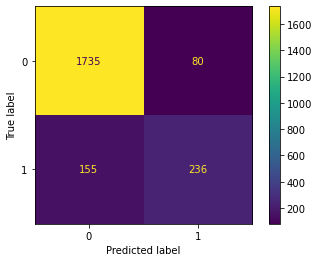

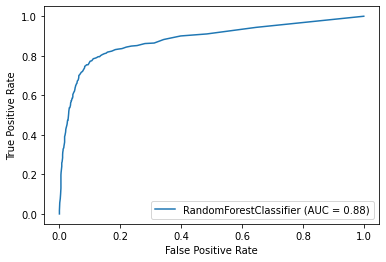

In [78]:
RF = RandomForestClassifier(class_weight = 'balanced').fit(X_train_scaled, y_train) # balance to handle sample inbalance
print('The accuracy for the training sets is ',RF.score(X_train_scaled, y_train).round(3))
print('The accuracy for the testing sets is ',RF.score(X_test_scaled, y_test).round(3))

plot_confusion_matrix(RF, X_test_scaled, y_test)
plot_roc_curve(RF, X_test_scaled, y_test)

In [79]:
pd.DataFrame(abs(RF.feature_importances_).T, X.columns, columns=['Feature Importance']).sort_values('Feature Importance')

,Feature Importance
creation_source_PERSONAL_PROJECTS,0.002771
creation_source_SIGNUP_GOOGLE_AUTH,0.003344
creation_source_SIGNUP,0.003577
invited_by_user_id,0.004549
creation_source_ORG_INVITE,0.006468
enabled_for_marketing_drip,0.009390
opted_in_to_mailing_list,0.011024
org_id,0.215813
last_session_creation_time,0.743065


The accuracy for the training sets is  0.677
The accuracy for the testing sets is  0.7


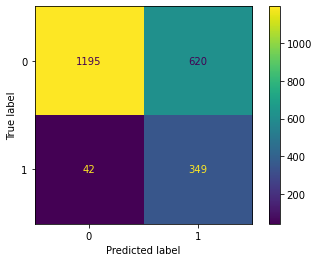

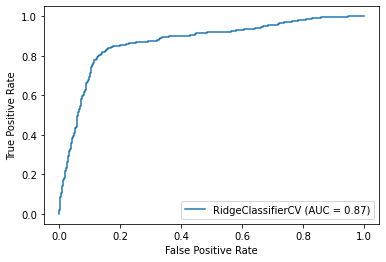

In [80]:
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], class_weight='balanced').fit(X_train_scaled, y_train)

print('The accuracy for the training sets is ',clf.score(X_train_scaled, y_train).round(3))
print('The accuracy for the testing sets is ',clf.score(X_test_scaled, y_test).round(3))

plot_confusion_matrix(clf, X_test_scaled, y_test)
plot_roc_curve(clf, X_test_scaled, y_test)


In [81]:
pd.DataFrame(abs(clf.coef_).T, X.columns, columns=['Coefficient']).sort_values('Coefficient')

,Coefficient
enabled_for_marketing_drip,0.000162
creation_source_PERSONAL_PROJECTS,0.007558
creation_source_SIGNUP_GOOGLE_AUTH,0.009557
opted_in_to_mailing_list,0.013359
creation_source_SIGNUP,0.037323
invited_by_user_id,0.041979
creation_source_ORG_INVITE,0.058818
org_id,0.066029
last_session_creation_time,0.572020


Based on the two models, RF model performs better than if we were to guess all false.  However, ridge classifer does not.  

Another thing to note is that last_session_creation time and org are both strongest indicator for whether if a person is an adopted user or not.  It would be interested if we were to trim down the model a little bit and just use these two factors and see if we can build a more accurate model.  